In [ ]:
from google.colab import drive

drive.mount("drive/")

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [ ]:
import pandas
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
random.seed(1)

In [ ]:
dataset_path = "IMDB Dataset.csv"
dataset_df = pandas.read_csv(dataset_path)

In [ ]:
dataset_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\bbr\b', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[\"'`]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    cleaned = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and token not in string.punctuation
    ]
    return ' '.join(cleaned)

dataset_df['cleaned_reviews'] = dataset_df['review'].apply(clean_text)
print(dataset_df['cleaned_reviews'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    one reviewer mentioned watching oz episode you...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: cleaned_reviews, dtype: object


In [ ]:
dataset_df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [ ]:
le = LabelEncoder()
dataset_df['sentiment_encoded'] = le.fit_transform(dataset_df['sentiment'])

In [ ]:
X = dataset_df['cleaned_reviews']
y = dataset_df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

In [ ]:
model_lstm = Sequential([
    Input(shape=(200,)),
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation="tanh", recurrent_activation="sigmoid"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,057 (3.13 MB)

 Trainable params: 821,057 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Learning rate decay: réduit le learning rate quand la validation loss plateau
lr_decay = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Réduire le LR de moitié
    patience=3,        # Attendre 3 epochs sans amélioration
    min_lr=1e-7,       # LR minimum
    verbose=1
)

In [ ]:
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#sauvgarder les versions des modeles
history = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.15,
    epochs=1000,
    callbacks=[early_stopping, lr_decay],
    batch_size=32
)

Epoch 1/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.7818 - loss: 0.4507 - val_accuracy: 0.8725 - val_loss: 0.3022 - learning_rate: 0.0010
Epoch 2/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8980 - loss: 0.2615 - val_accuracy: 0.8678 - val_loss: 0.3076 - learning_rate: 0.0010
Epoch 3/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.9236 - loss: 0.2017 - val_accuracy: 0.8752 - val_loss: 0.3178 - learning_rate: 0.0010
Epoch 4/1000
1062/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9419 - loss: 0.1614
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9419 - loss: 0.1614 - val_accuracy: 0.8648 - val_loss: 0.3739 - learning_rate: 0.0010
Epoch 5/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9655 - loss: 0.1049 - val_accuracy: 0.8758 - val_loss: 0.3910 - learning_rate: 5.0000e-04
Epoch 6/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms

In [ ]:
model_lstm.fit(X_train_pad, y_train, validation_split=0.15, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9084 - loss: 0.2369 - val_accuracy: 0.8792 - val_loss: 0.2878
Epoch 2/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.9329 - loss: 0.1815 - val_accuracy: 0.8802 - val_loss: 0.3095
Epoch 3/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.9500 - loss: 0.1421 - val_accuracy: 0.8715 - val_loss: 0.3360
Epoch 4/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9666 - loss: 0.1043 - val_accuracy: 0.8608 - val_loss: 0.3896
Epoch 5/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9764 - loss: 0.0767 - val_accuracy: 0.8662 - val_loss: 0.4619
Epoch 6/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9809 - loss: 0.0610 - val_accuracy: 0.8672 - val_loss: 0.5038


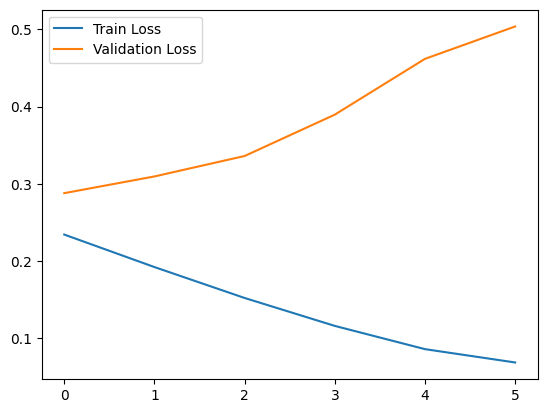

In [ ]:
plt.plot(model_lstm.history.history["loss"])
plt.plot(model_lstm.history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D
input_layer = Input(shape=(200,))

embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)

lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)

attention_layer = Attention()([lstm_layer, lstm_layer])

# Add GlobalAveragePooling1D layer to reduce the output shape
pooling_layer = GlobalAveragePooling1D()(attention_layer)


output_layer = Dense(1, activation='sigmoid')(pooling_layer)

model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)
model_lstm_attention.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 128)  │    640,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 200, 128)  │    131,584 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 200, 128)  │          0 │ lstm_5[0][0],     │
│ (Attention)         │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm_attention.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_lstm_attention.fit(X_train_pad, y_train, validation_split=0.15, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7398 - loss: 0.4849 - val_accuracy: 0.8802 - val_loss: 0.2942
Epoch 2/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9039 - loss: 0.2447 - val_accuracy: 0.8850 - val_loss: 0.2779
Epoch 3/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9272 - loss: 0.1978 - val_accuracy: 0.8830 - val_loss: 0.2942
Epoch 4/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9377 - loss: 0.1616 - val_accuracy: 0.8770 - val_loss: 0.3512
Epoch 5/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9585 - loss: 0.1163 - val_accuracy: 0.8713 - val_loss: 0.3790
Epoch 6/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9684 - loss: 0.0922 - val_accuracy: 0.8707 - val_loss: 0.4147
Epoch 7/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9759 - loss: 0.0726 - val_accuracy: 0.8683 - val_loss: 0.5222


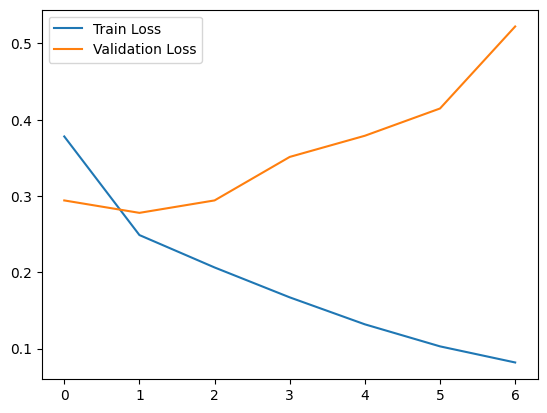

In [ ]:
plt.plot(model_lstm_attention.history.history["loss"])
plt.plot(model_lstm_attention.history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

In [ ]:
model_lstm_attention.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_lstm_attention.fit(X_train_pad, y_train, validation_split=0.15, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9279 - loss: 0.1891 - val_accuracy: 0.8832 - val_loss: 0.2939
Epoch 2/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9409 - loss: 0.1561 - val_accuracy: 0.8792 - val_loss: 0.3279
Epoch 3/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9532 - loss: 0.1248 - val_accuracy: 0.8757 - val_loss: 0.3632
Epoch 4/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9649 - loss: 0.0992 - val_accuracy: 0.8668 - val_loss: 0.4400
Epoch 5/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9762 - loss: 0.0711 - val_accuracy: 0.8645 - val_loss: 0.5433
Epoch 6/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9820 - loss: 0.0549 - val_accuracy: 0.8658 - val_loss: 0.5603


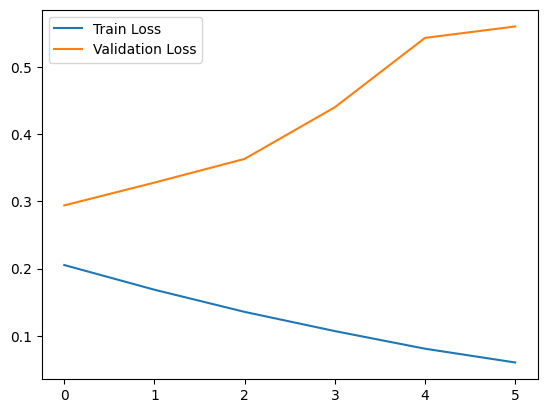

In [ ]:
plt.plot(model_lstm_attention.history.history["loss"])
plt.plot(model_lstm_attention.history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

#Explication courte du code ROC

- Ce code calcule et trace la courbe ROC pour évaluer la performance du modèle.

- On prédit les probabilités sur les données test.

- on calcule les taux de faux positifs (FPR) et vrais positifs (TPR) pour plusieurs seuils.

- L’AUC mesure la qualité globale du modèle (plus c’est proche de 1, mieux c’est).

- On trouve le seuil optimal qui maximise la différence TPR - FPR (statistique de Youden), ce qui équilibre sensibilité et spécificité.

- On affiche la courbe ROC avec ce seuil optimal marqué, pour mieux choisir à partir de quelle probabilité on classe un exemple comme positif.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Seuil optimal : 0.5117
TPR (sensibilité) au seuil optimal : 0.8805
FPR (1-spécificité) au seuil optimal : 0.1103
Valeur maximale de Youden (TPR-FPR) : 0.7703


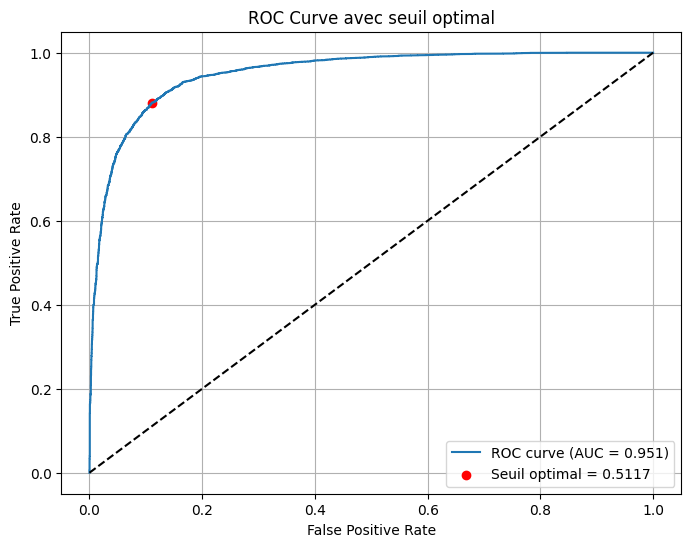

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


# Prédictions des probabilités sur l'ensemble de test
y_pred_proba = model_lstm_attention.predict(X_test_pad)

# Calcul des taux de faux positifs (FPR), vrais positifs (TPR) et des seuils
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcul de l'AUC (aire sous la courbe ROC)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calcul de la statistique de Youden : TPR - FPR pour chaque seuil
J = tpr - fpr

# Recherche de l'indice du seuil optimal (maximisant la statistique de Youden)
ix = np.argmax(J)

# Extraction du seuil optimal et des valeurs associées
best_thresh = thresholds[ix]
best_J = J[ix]
best_tpr = tpr[ix]
best_fpr = fpr[ix]

# Affichage des résultats du seuil optimal
print(f"Seuil optimal : {best_thresh:.4f}")
print(f"TPR (sensibilité) au seuil optimal : {best_tpr:.4f}")
print(f"FPR (1-spécificité) au seuil optimal : {best_fpr:.4f}")
print(f"Valeur maximale de Youden (TPR-FPR) : {best_J:.4f}")

# Tracé de la courbe ROC avec indication du seuil optimal
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')  # Courbe ROC
plt.scatter(best_fpr, best_tpr, color='red', label=f'Seuil optimal = {best_thresh:.4f}')  # Point seuil optimal
plt.plot([0,1], [0,1], 'k--')  # Ligne diagonale représentant un classifieur aléatoire
plt.xlabel('False Positive Rate')  # Axe X : taux de faux positifs
plt.ylabel('True Positive Rate')   # Axe Y : taux de vrais positifs (rappel)
plt.title('ROC Curve avec seuil optimal')
plt.legend()
plt.grid(True)
plt.show()


##  Interprétation  de la courbe ROC

La courbe **ROC**  est un outil  permettant d’évaluer la qualité d’un modèle de **classification binaire**, en testant ses performances pour différents **seuils de décision**.

- **Axe des abscisses (X)** : représente le **taux de faux positifs**  c’est-à-dire la proportion de négatifs mal classés comme positifs.
- **Axe des ordonnées (Y)** : correspond au **taux de vrais positifs** c’est-à-dire la proportion de positifs correctement identifiés.
- La **diagonale** de la courbe (de (0,0) à (1,1)) représente le comportement d’un **modèle aléatoire** sans pouvoir de discrimination.
- Plus la **courbe est proche du coin supérieur gauche**, plus le modèle est performant.
- L’indicateur **AUC**  mesure la qualité  modèle :
  - **AUC = 0.5** : performance équivalente au hasard.
  - **AUC = 1.0** : performance parfaite.
  - Plus l’AUC est proche de 1, mieux est la qualité 

Le **seuil optimal** est souvent défini comme celui qui **maximise la statistique de Youden** 

---

##  Résultats de l’analyse 

- **Seuil  (Youden)** : `0.5117`  
  → Ce seuil maximise le compromis entre vraies détections et fausses alertes.

- **Sensibilité** : `0.8805`  
  → Le modèle détecte correctement environ **88 %** des cas positifs.

- **Taux de faux positifs** : `0.1103`  
  → Environ **11 %** des cas négatifs sont mal classés comme positifs.

- **Statistique de Youden** : `0.7703`  
  → Cette valeur élevée indique un **très bon équilibre** entre **sensibilité** et **spécificité**.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# On prédit les probabilités avec le modèle
y_pred_proba = model_lstm_attention.predict(X_test_pad)

# On choisit le seuil optimal (0.5117)
seuil = 0.5117

# On transforme les probabilités en 0 ou 1 selon ce seuil
y_pred = (y_pred_proba >= seuil).astype(int).reshape(-1)

# On calcule et affiche la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(cm)

# On affiche le rapport de classification (précision, rappel, f1-score)
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Matrice de confusion :
[[4414  547]
 [ 603 4436]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4961
           1       0.89      0.88      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.89     10000

